In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import RandAugment

# Check if GPU is available and set device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda:0


# Load the Dataset / pre-process & Create Dataloaders 

In [2]:
# Define transformations for the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # random crop to 32x32 for regularisation
    transforms.RandomHorizontalFlip(),  # data augmentation for regularisation
    RandAugment(num_ops=2, magnitude=9),  # Adding RandAugment for stronger data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    pin_memory=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
testloader = DataLoader(
    testset,
    batch_size=1028,
    shuffle=False,
    pin_memory=True
)

# CIFAR-10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Model Architecture 

In [3]:
class OutputBlock(nn.Module):

    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()
        
        # First FC layer: reduce from input channels to 256
        self.fc1 = nn.Linear(in_channels, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        # Second FC layer: reduce from 256 to 128
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        # Final FC layer: reduce from 128 to num_classes
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Input shape: [batch_size, in_channels, height, width]
        
        # Compute the average value of each channel of x
        # Shape: [batch_size, in_channels, height, width] -> [batch_size, in_channels]
        avg_channels = x.mean(dim=(2, 3))
        
        # First FC layer with batch norm, ReLU, and dropout
        # Shape: [batch_size, in_channels] -> [batch_size, 256]
        x = self.fc1(avg_channels)
        # Shape: [batch_size, 256] 
        x = self.bn1(x)
        # Shape: [batch_size, 256] 
        x = F.relu(x)
        # Shape: [batch_size, 256] 
        x = self.dropout1(x)
        
        # Second FC layer with batch norm, ReLU, and dropout
        # Shape: [batch_size, 256] -> [batch_size, 128]
        x = self.fc2(x)
        # Shape: [batch_size, 128] 
        x = self.bn2(x)
        # Shape: [batch_size, 128] 
        x = F.relu(x)
        # Shape: [batch_size, 128] 
        x = self.dropout2(x)
        
        # Final FC layer to produce logits
        # Shape: [batch_size, 128] -> [batch_size, num_classes]
        logits = self.fc3(x)
        
        return logits


class IntermediateBlock(nn.Module):

    def __init__(self, in_channels, out_channels, layer_configs=None, use_batchnorm_for_each_layer=True, downsample=False):
        super(IntermediateBlock, self).__init__()
        self.use_batchnorm = use_batchnorm_for_each_layer
        
        # Create layers based on provided configurations
        self.conv_layers = nn.ModuleList()
        self.num_layers = len(layer_configs)
        
        for config in layer_configs:
            # Extract parameters with defaults
            kernel_size = config.get('kernel_size', 3)
            padding = config.get('padding', 1)
            dilation = config.get('dilation', 1)
            groups = config.get('groups', 1)
            bias = config.get('bias', True)
            
            self.conv_layers.append(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=kernel_size,
                    padding=padding,
                    dilation=dilation,
                    groups=groups,
                    bias=bias
                )
            )
        
        # Add batch normalization for each layer if enabled
        if use_batchnorm_for_each_layer:
            self.bn_layers = nn.ModuleList([
                nn.BatchNorm2d(out_channels)
                for _ in range(self.num_layers)
            ])
        
        # Fully connected layer to compute the weights
        self.fc = nn.Linear(in_channels, self.num_layers)
        
        # Optional max pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if downsample else None
        
    def forward(self, x):
        # Compute the average value of each channel of x
        avg_channels = x.mean(dim=(2, 3))
        
        # Compute weights using the fully connected layer
        weights = self.fc(avg_channels)
        weights = F.softmax(weights, dim=1)  # Normalize weights
        
        # Apply each convolutional layer to the input - with batchnorm if enabled - no relu
        # if self.use_batchnorm:
        #     conv_outputs = [self.bn_layers[i](self.conv_layers[i](x)) for i in range(self.num_layers)]
        # else:
        #     conv_outputs = [layer(x) for layer in self.conv_layers]

        # Apply relu and batchnorm if enabled 
        if self.use_batchnorm:
            # Add ReLU after BatchNorm for each layer
            conv_outputs = [F.relu(self.bn_layers[i](self.conv_layers[i](x))) for i in range(self.num_layers)]
        else:
            # Add ReLU without BatchNorm
            conv_outputs = [F.relu(layer(x)) for layer in self.conv_layers]
            
        # Weight and combine the outputs
        weights = weights.view(weights.size(0), self.num_layers, 1, 1, 1)
        stacked_outputs = torch.stack(conv_outputs, dim=1)
        weighted_sum = (stacked_outputs * weights).sum(dim=1)
        
        # Apply downsampling if enabled
        if self.pool is not None:
            weighted_sum = self.pool(weighted_sum)
        
        return weighted_sum

class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        
        # Default layer configurations
        default_layer_configs = [
            # Layer 1: Standard 3×3 convolution
            {'kernel_size': 3, 'padding': 1, 'dilation': 1},         
            {'kernel_size': 5, 'padding': 2, 'dilation': 1},
            {'kernel_size': 3, 'padding': 2, 'dilation': 2},
            {'kernel_size': 1, 'padding': 0, 'dilation': 1},          
            {'kernel_size': 3, 'padding': 1, 'dilation': 1},          
            {'kernel_size': 7, 'padding': 3, 'dilation': 1},         
            {'kernel_size': 3, 'padding': 3, 'dilation': 3}
        ]
        
        # Default block configurations
        block_configs = {
            'block_0': {
                'in_channels': 3,
                'out_channels': 48,    
                'downsample': False,   
                'use_batchnorm': True,
                'layer_configs': default_layer_configs 
            },
            'block_1': {
                'in_channels': 48,
                'out_channels': 96,    
                'downsample': False,   
                'use_batchnorm': True,
                'layer_configs': default_layer_configs
            },
            'block_2': {
                'in_channels': 96,
                'out_channels': 96,    # Consolidation block
                'downsample': True,    # First downsampling here (16×16)
                'use_batchnorm': True,
                'layer_configs': default_layer_configs
            },
            'block_3': {
                'in_channels': 96,
                'out_channels': 192,   
                'downsample': False,   
                'use_batchnorm': True,
                'layer_configs': default_layer_configs
            },
            'block_4': {
                'in_channels': 192,
                'out_channels': 192,   
                'downsample': True,    
                'use_batchnorm': True,
                'layer_configs': default_layer_configs
            },
            'block_5': {
                'in_channels': 192,
                'out_channels': 384,   
                'downsample': False,   
                'use_batchnorm': True,
                'layer_configs': default_layer_configs
            },
            'block_6': {
                'in_channels': 384,
                'out_channels': 384,   
                'downsample': True,    
                'use_batchnorm': True,
                'layer_configs': default_layer_configs
            }
        }
        self.blocks = nn.ModuleList()

        # Create blocks# Add BatchNorm between blocks
        self.between_block_bns = nn.ModuleList()

        for i in range(len(block_configs)):
            block_name = f'block_{i}'
            if block_name in block_configs:
                config = block_configs[block_name]
                self.blocks.append(
                    IntermediateBlock(
                        in_channels=config['in_channels'],
                        out_channels=config['out_channels'],
                        layer_configs=config['layer_configs'],
                        use_batchnorm_for_each_layer=config['use_batchnorm'],  # Match parameter name
                        downsample=config['downsample']
                    )
                )
        
        # Add ReLU activation between blocks
        self.relu = nn.ReLU(inplace=True)
        
        # Create the output block - use the out_channels from the last block
        final_block_name = f'block_{len(self.blocks)-1}'
        final_channels = block_configs[final_block_name]['out_channels']
        self.output_block = OutputBlock(final_channels)
        
    def forward(self, x):
        # Pass input through each intermediate block
        for block in self.blocks:
            x = self.relu(block(x))
        
        # Pass through output block to get logits
        logits = self.output_block(x)
        
        return logits

# training & Evaluation 

In [4]:
def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}], Step [{i+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    # Calculate epoch accuracy
    train_accuracy = 100. * correct / total
    return train_accuracy

def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate metrics
    test_accuracy = 100. * correct / total
    avg_test_loss = test_loss / len(dataloader)
    
    print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    return test_accuracy, avg_test_loss                             

# Plottong funcitons 

In [5]:
def plot_learning_curves(train_accuracies, test_accuracies, test_losses, num_epochs):
    # Plot the learning curves
    plt.figure(figsize=(12, 5))

    # Plot training and test accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, 'r-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot test loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), test_losses, 'g-')
    plt.title('Test Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()


# Excecution Main 


CUDA cache cleared
Current learning rate: 0.001s: 1.9335, Acc: 16.79%
Epoch [1/100] - Train Acc: 17.65% - Test Acc: 27.68% - Test Loss: 1.8351
New best model with accuracy: 27.68%
Model saved to ./models/cifar10_model.pth
Current learning rate: 0.001s: 1.6697, Acc: 32.31%
Epoch [2/100] - Train Acc: 32.96% - Test Acc: 34.27% - Test Loss: 1.8278
New best model with accuracy: 34.27%
Model saved to ./models/cifar10_model.pth
Current learning rate: 0.001s: 1.4037, Acc: 45.50%
Epoch [3/100] - Train Acc: 45.86% - Test Acc: 41.64% - Test Loss: 1.8457
New best model with accuracy: 41.64%
Model saved to ./models/cifar10_model.pth
Current learning rate: 0.001s: 1.1920, Acc: 55.08%
Epoch [4/100] - Train Acc: 55.41% - Test Acc: 42.40% - Test Loss: 1.9297
New best model with accuracy: 42.40%
Model saved to ./models/cifar10_model.pth
Current learning rate: 0.001s: 1.0553, Acc: 60.71%
Epoch [5/100] - Train Acc: 60.87% - Test Acc: 51.67% - Test Loss: 1.4612
New best model with accuracy: 51.67%
Model sa

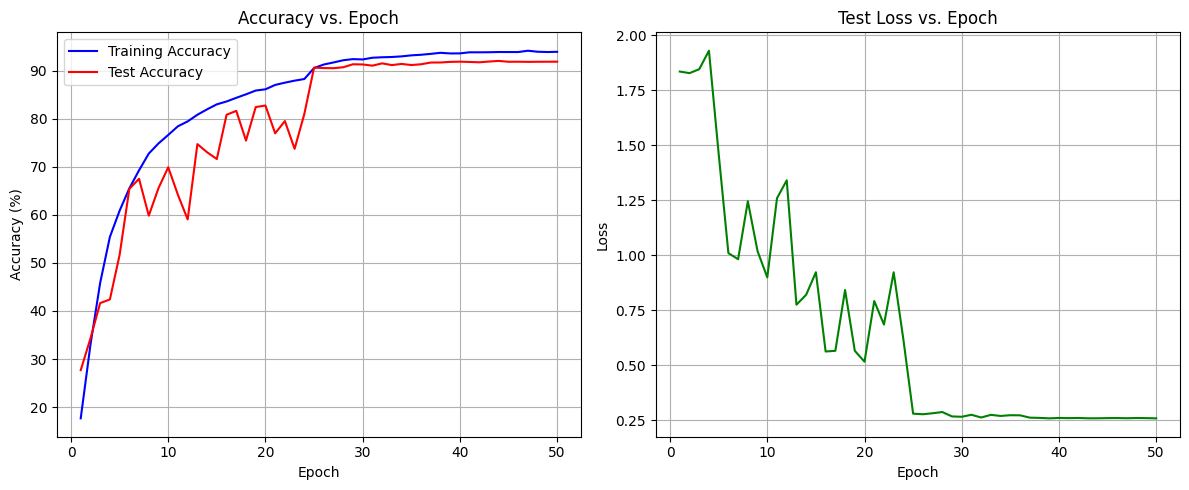

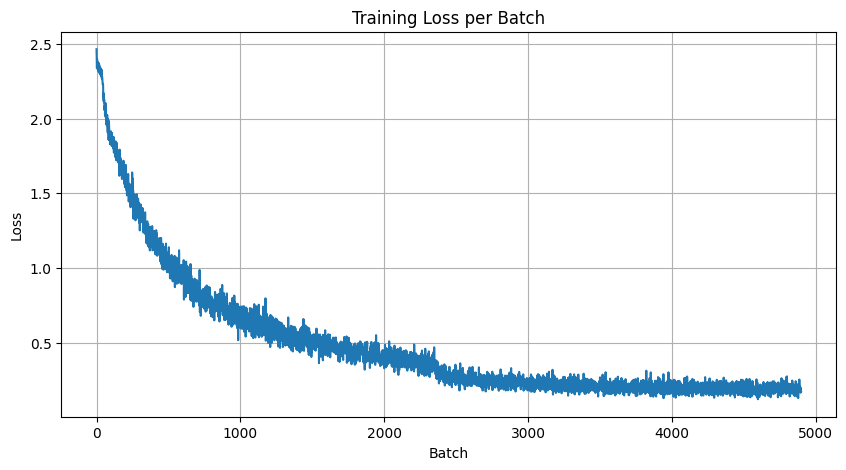

In [6]:
def main():
    # Create models directory and set model save path
    models_dir = './models'
    os.makedirs(models_dir, exist_ok=True)
    model_save_path = os.path.join(models_dir, 'cifar10_model.pth')
    
    # Clear CUDA cache to free up GPU memory before training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("CUDA cache cleared")
    
    # Initialize the model
    model = CIFAR10Net().to(device)
    
    # Option to load previous model 
    load_previous_model = True         
    load_previous_model = False                       # uncomment to not load a previous model
                                           
    if load_previous_model and os.path.exists(model_save_path):
        try:
            model.load_state_dict(torch.load(model_save_path))
            print(f"Loaded previous model from {model_save_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) # 1e-4 was provided as a good starting point
    
    # Learning rate scheduler with patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.1, patience=3
        )
                       
    # Lists to store metrics for plotting
    batch_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []
    
    # Early stopping parameter
    patience = 6

    # Early stopping variables
    best_accuracy = 0.0
    best_model_state = None
    patience_counter = 0
    
    # Maximum number of epochs
    num_epochs = 100
    
    # Train the model
    for epoch in range(num_epochs):
        # Train for one epoch
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            batch_losses.append(loss.item())  # Store each batch loss
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
                        
            if (i+1) % 10 == 0:
                print(f'Epoch [{epoch+1}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/10:.4f}, Acc: {100.*correct/total:.2f}%', end='\r', flush=True)
                running_loss = 0.0
        
        # Calculate epoch accuracy
        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        # Calculate metrics
        test_accuracy = 100. * correct / total
        avg_test_loss = test_loss / len(testloader)
        test_accuracies.append(test_accuracy)
        test_losses.append(avg_test_loss)
        
        # Update learning rate scheduler based on validation accuracy
        scheduler.step(test_accuracy)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f}')
        
        # Check for improvement
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'New best model with accuracy: {best_accuracy:.2f}%')
            
            # Save the best model (overwrites previous best)
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}', end='\r', flush=True)
        else:
            patience_counter += 1
            print(f'No improvement for {patience_counter} epochs. Best accuracy: {best_accuracy:.2f}%')
        
        # Early stopping check
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    print('Finished Training')
    
    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Restored best model with accuracy: {best_accuracy:.2f}%')
    
    # Plot the learning curves
    plot_learning_curves(train_accuracies, test_accuracies, test_losses, len(train_accuracies))
    
    # Plot batch losses
    plt.figure(figsize=(13.33, 5))
    plt.plot(batch_losses)
    plt.title('Training Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('batch_losses.png')
    plt.show()

if __name__ == "__main__":
    main()